In [1]:
from chromatic_fitting import *
from chromatic import Rainbow, SimulatedRainbow
from pymc3 import Normal, Uniform #Model, HalfNormal,Deterministic,  plot_trace, sample_prior_predictive, sample_posterior_predictive
# fromtqdm import tqdm
# from pymc3_ext import eval_in_model, optimize, sample, ParameterGroup
from exoplanet import QuadLimbDark, ImpactParameter

plt.matplotlib.style.use('default')

Running on Python v3.8.13 (default, Mar 28 2022, 06:13:39) 
[Clang 12.0.0 ]
Running on numpy v1.22.1


Create Synthetic Rainbow + Transit

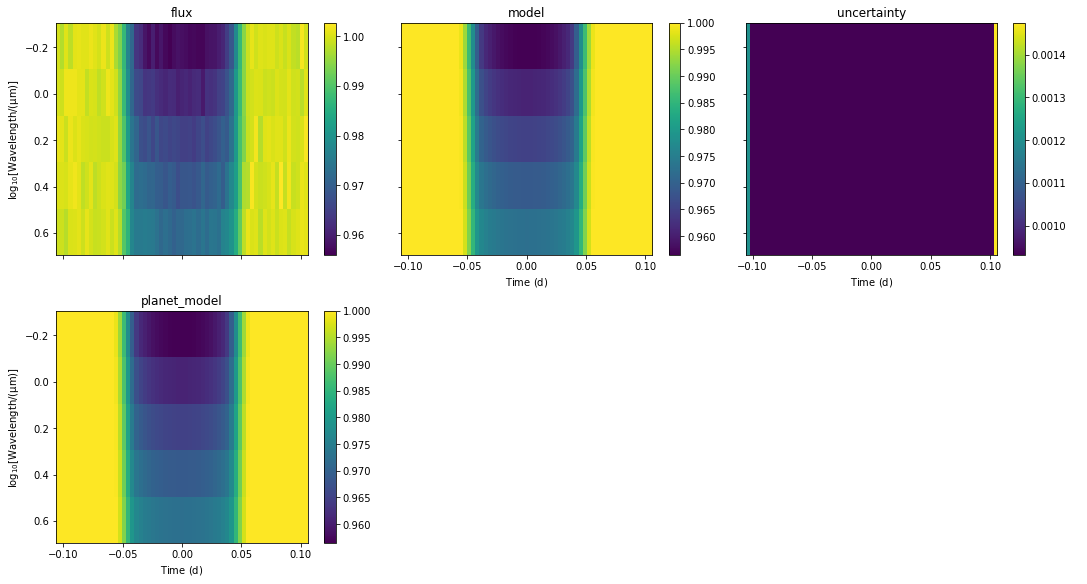

In [2]:
# create transit rainbow:
r = SimulatedRainbow(dt=1 * u.minute, R=50).inject_noise(signal_to_noise=100)

# add transit:
r = r.inject_transit(
        planet_radius=np.linspace(0.2, 0.15, r.nwave))

# bin:
rbin5 = r.bin(nwavelengths=int(r.nwave/5), dt=5 * u.minute)

rbin5.imshow_quantities();

## Fit with PyMC3 Transit Model

Create a transit model

In [3]:
# create transit model:
t = TransitModel()

# add empty pymc3 model:
t.initialize_empty_model()

# add our parameters:
t.setup_parameters(
                  period=1, # a fixed value!
                   epoch=Fitted(Uniform,lower=-0.05,upper=0.05), # one fitted value across all wavelengths
                   stellar_radius = Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   stellar_mass =Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   radius_ratio=WavelikeFitted(Normal, mu=0.5, sigma=0.05), # a value fitted for every wavelength!
                   impact_parameter=Fitted(ImpactParameter,ror=0.15,testval=0.44),
                   limb_darkening=WavelikeFitted(QuadLimbDark,testval=[0.05,0.35]),
                    baseline = WavelikeFitted(Normal, mu=1.0, sigma=0.05), # I will keep this fixed for when we add a polynomial model!
                )

# print a summary of all params:
t.summarize_parameters()

transit_stellar_radius =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='stellar_radius') 🧮>

transit_stellar_mass =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='stellar_mass') 🧮>

transit_radius_ratio =
  <🧮 WavelikeFitted Normal(mu=0.5, sigma=0.05, name='radius_ratio') for each wavelength 🧮>

transit_period =
  <🧮 Fixed | 1 🧮>

transit_epoch =
  <🧮 Fitted Uniform(lower=-0.05, upper=0.05, name='epoch') 🧮>

transit_baseline =
  <🧮 WavelikeFitted Normal(mu=1.0, sigma=0.05, name='baseline') for each wavelength 🧮>

transit_impact_parameter =
  <🧮 Fitted ImpactParameter(ror=0.15, testval=0.44, name='impact_parameter') 🧮>

transit_limb_darkening =
  <🧮 WavelikeFitted QuadLimbDark(testval=[0.05, 0.35], name='limb_darkening') for each wavelength 🧮>



Now we can attach the data and setup the model!

In [ ]:
# attach the Rainbow object to the model:
t.attach_data(rbin5)

# setup the lightcurves for the transit model:
t.setup_lightcurves()

# relate the "actual" data to the model (using a Normal likelihood function)
t.setup_likelihood()

Let's check the model has the parameters we expect:

In [ ]:
print(t.pymc3_model)

Now we can plot a couple of priors - do they look OK?

In [ ]:
t.plot_priors()

Another check is does the orbit look good?

In [ ]:
t.plot_orbit()

Finally, if we're happy, we can try sampling! This can take a while if there's lots of parameters!

In [ ]:
t.sample(tune=3000, draws=3000, chains=4, cores=4)

We might want to see a summary table of the MCMC sampling results:

In [ ]:
t.summarize(round_to=7, fmt='wide')

We might also want to see a couple of posterior samples as a "quick-look" check!

In [ ]:
t.plot_posteriors()